#  Материалы
* [Презентация](https://disk.yandex.ru/i/hwz5kF6pHC6WAg)
* [Дашборд](https://public.tableau.com/app/profile/bazedius/viz/_16665173922310/Dashboard1?publish=yes)

# Формирование модели монетизации игрового приложения

Существует некоторое игровое приложение, где игроки строят космическую базу, сражаются с другими игроками и/или пытаются обогнать их в техническом развитии. Так, завершение уровня требует от игрока выполнения одного из двух условий:
- победа над первым врагом;
- реализация проекта - разработка орбитальной сборки спутников.

Предполагается, что приложение будет окупаться за счет рекламы. Основная монетизация игры на данном этапе только планируется. Но предварительно можно считать, что показ рекламы будет происходить на экране с выбором типа объекта для постройки. Подобный подход связан с важным противоречием:
- пользователь уйдёт, если начать показывать ему рекламу раньше, чем игра его затянет;
- чем позже создатели игры включат рекламу, тем меньше они заработают.

Необходимо выбрать оптимальное время для запуска рекламы и, зная расходы на продвижение игры, рассчитать её окупаемость при разных сценариях, имея в распоряжении данные о первых игроках, которые начали пользоваться приложением в период с 4 по 10 мая включительно.

Таким образом, задача может быть сформулирована следующим образом: сформировать модель монетизации игрового приложения с учетом порога снижения количества рекламы, обеспечивающего минимизацию недовольства пользователей при условии сохранения окупаемости.

Решение данной задачи включает в себя реализацию нескольких основных этапов.

## Загрузка и предобработка данных

Для начала загрузим необходимые в работе библиотеки.

In [1]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
from datetime import datetime, timedelta

Далее последовательно загрузим и обработаем имеющиеся файлы с данными.

### Файл game_actions

Загрузим данные из соответствующего файла.

In [2]:
# считываем файл
actions = pd.read_csv('game_actions.csv')

In [3]:
# выводим основную информацию
actions.info()
actions.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB


,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN


Мы видим, что в целом названия колонок имеют корректный вид, однако данные в колонке с датой и временем представлены в строковом формате, исправим это.

In [4]:
# меняем тип данных в столбце с датой и временем
actions['event_datetime'] = pd.to_datetime(actions['event_datetime'])

Мы также видим, что в двух столбцах есть пропуска. Начнем обработку со столбца building_type. Сперва посмотрим какие вообще значения принимают записи из этого столбца.

In [5]:
# выводим уникальные значения в столбце building_type
actions['building_type'].unique()

array(['assembly_shop', 'spaceport', nan, 'research_center'], dtype=object)

Можно предположить, что пустые значения в столбце building_type относятся к событиям, не связанным со строительством зданий. Проверим это.

In [6]:
# выводим типы и число событий с пустыми значениями в столбце building_type
actions[actions['building_type'].isna()]['event'].value_counts()

finished_stage_1    5817
project             1866
Name: event, dtype: int64

Действительно, все события без указания типа здания относятся к событиям, завершающим игру. А количество таких событий указывает на отсутствие "реальных" пропусков в данных об объектах строительства. Чтобы окончательно убедится в этом, посмотрим отдельно информацию по событиям, относящимся к строительству зданий.

In [7]:
# выводим основную информацию только по событиям типа building
actions[actions['event'] == 'building'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127957 entries, 0 to 135637
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   event_datetime  127957 non-null  datetime64[ns]
 1   event           127957 non-null  object        
 2   building_type   127957 non-null  object        
 3   user_id         127957 non-null  object        
 4   project_type    0 non-null       object        
dtypes: datetime64[ns](1), object(4)
memory usage: 5.9+ MB


Таким образом, в столбце building_type нет "реальных" пропусков.

Аналогичным способом изучим пропуска в столбце project_type, предположив, что записи в нем относятся только к событиям, связанным с реализацией проекта.

In [8]:
# выводим уникальные значения в столбце project_type
actions['project_type'].unique()

array([nan, 'satellite_orbital_assembly'], dtype=object)

In [9]:
# выводим типы и число событий с пустыми значениями в столбце project_type
actions[actions['project_type'].isna()]['event'].value_counts()

building            127957
finished_stage_1      5817
Name: event, dtype: int64

In [10]:
# выводим основную информацию только по событиям типа project
actions[actions['event'] == 'project'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1866 entries, 47121 to 135630
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   event_datetime  1866 non-null   datetime64[ns]
 1   event           1866 non-null   object        
 2   building_type   0 non-null      object        
 3   user_id         1866 non-null   object        
 4   project_type    1866 non-null   object        
dtypes: datetime64[ns](1), object(4)
memory usage: 87.5+ KB


Таким образом, в столбце project_type также нет "реальных" пропусков.

Теперь проверим данные на дубликаты. 

In [11]:
# выведем повторяющиеся строки при их наличии
actions[actions.duplicated(keep=False)]

,event_datetime,event,building_type,user_id,project_type
74890,2020-05-10 18:41:56,building,research_center,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,NaN
74891,2020-05-10 18:41:56,building,research_center,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,NaN


Всего одна строчка дублирует другую. От такого повтора вполне можно избавиться, не опасаясь за полноту данных.

In [12]:
# устраняем дубликаты
actions = actions.drop_duplicates()

Проверим внесенные изменения.

In [13]:
# выводим основную информацию
actions.info()
actions.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135639 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   event_datetime  135639 non-null  datetime64[ns]
 1   event           135639 non-null  object        
 2   building_type   127956 non-null  object        
 3   user_id         135639 non-null  object        
 4   project_type    1866 non-null    object        
dtypes: datetime64[ns](1), object(4)
memory usage: 6.2+ MB


,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN


Типа данных был успешно изменен, а одна строчка с повтором удалена.

### Файл ad_costs

Загрузим данные из соответствующего файла.

In [14]:
# считываем файл
costs = pd.read_csv('ad_costs.csv')

In [15]:
# выводим основную информацию
costs.info()
costs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes


,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796


В целом данные выглядят нормально. Заменим тип данных в столбце c указанием дня.

In [16]:
# меняем тип данных в столбце с датой
costs['day'] = pd.to_datetime(costs['day'])

Также посмотрим отдельно на значения в столбцах source и day.

In [17]:
# выводим уникальные значения в столбце source
costs['source'].unique()

array(['facebook_ads', 'instagram_new_adverts', 'yandex_direct',
       'youtube_channel_reklama'], dtype=object)

Всего пользователи приходят в приложение из 4-х различных каналов привлечения.

In [18]:
# выводим уникальные значения в столбце day
costs['day'].unique()

array(['2020-05-03T00:00:00.000000000', '2020-05-04T00:00:00.000000000',
       '2020-05-05T00:00:00.000000000', '2020-05-06T00:00:00.000000000',
       '2020-05-07T00:00:00.000000000', '2020-05-08T00:00:00.000000000',
       '2020-05-09T00:00:00.000000000'], dtype='datetime64[ns]')

Похоже, что даты привлечения пользователей "смещены" на один день относительно периода анализа их активности. Учтем это в последующих расчетах рентабельности.

### Файл user_source

In [19]:
# считываем файл
sources = pd.read_csv('user_source.csv')

In [20]:
# выводим основную информацию
sources.info()
sources.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 212.2+ KB


,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads


В целом данные также выглядят нормально. Посмотрим отдельно на значения в столбце source.

In [21]:
# выводим уникальные значения в столбце source
sources['source'].unique()

array(['facebook_ads', 'yandex_direct', 'youtube_channel_reklama',
       'instagram_new_adverts'], dtype=object)

Источники привлечения в данном случае совпадают с источниками из предыдущего датасета.

Теперь проверим данные на дубликаты.

In [22]:
# выведем повторяющиеся строки при их наличии
sources[sources.duplicated(keep=False)]

,user_id,source


Дубликатов не было выявлено. Пропуска в данных тоже отсутствуют, исходя из сводки основной информации.

## Исследовательский анализ данных

Посчитаем количество событий, приходящихся в среднем на одного пользователя.

In [23]:
# посчитаем число уникальных пользователей
users = len(actions['user_id'].unique())

users

13576

In [24]:
# посчитаем число всех событий
events = len(actions)

events

135639

In [25]:
# посчитаем число событий на одного пользователя
events/users

9.991087212728344

Получается, что на одного пользователя приходится примерно 10 событий из списка доступных действий. Но, так как нас в первую очередь интересует количество "рекламных" событий, а реклама в приложении привязана к выбору постройки, посчитаем также абсолютное и относительное число событий, связанных со строительством зданий в игре. 

In [26]:
# посчитаем число событий, связанных со строительством 
builds = len(actions[actions['event'] == 'building'])

builds

127956

In [27]:
# посчитаем число событий, связанных со строительством, на одного пользователя
builds/users

9.425162050677667

Итого, один пользователь в среднем строит в игре порядка 9 зданий и видит такое же количество рекламных сообщений.

Теперь посмотрим на соотношение различных типов зданий, которые строят пользователи.

In [28]:
#считаем количество событий в группировке по типам строений
buildings_grouped = actions.groupby('building_type').agg({'event': 'count'})

buildings_grouped

,event
building_type,
assembly_shop,54494
research_center,14137
spaceport,59325


Для наглядности построим диаграмму на основе полученных данных.

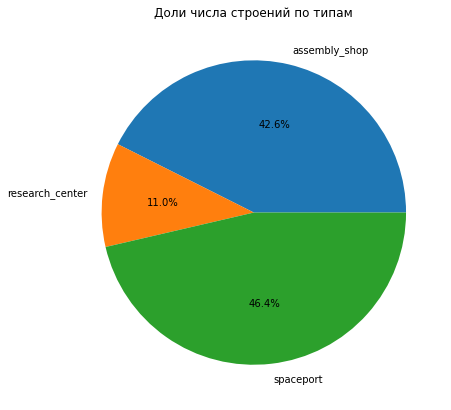

In [29]:
# строим круговую диаграмму
plt.figure(figsize=(7, 7))
plt.pie(buildings_grouped['event'], labels=buildings_grouped.index, autopct='%1.1f%%')
plt.title('Доли числа строений по типам')
plt.show()

Сборный цех и космопорт игроки строят со сходной частотой (около 42-46%), а вот исследовательский центр - гораздо реже (11%), что логично, так как это строение требуется для реализации завершающего уровень проекта.

Теперь посмотрим на данные о рекламных затратах. Сперва поймем общую сумму затрат и величину затрат на одного пользователя.

In [30]:
# посчитаем сумму затрат на привлечение
total_costs = costs['cost'].sum()

total_costs

7603.576986788023

In [31]:
# посчитаем затраты на привлечение одного пользователя
total_costs/users

0.5600749106355349

Таким образом, всего на привлечение пользователей тратится более 7600 условных единиц, а один пользовать "стоит" компании 0.56 у.е.   

Посмотрим, как затраты распределяются по различным источникам.

In [32]:
#считаем сумму затрат в группировке по источникам
costs_grouped = costs.groupby('source').agg({'cost': 'sum'})

costs_grouped

,cost
source,
facebook_ads,2140.904643
instagram_new_adverts,2161.441691
yandex_direct,2233.111449
youtube_channel_reklama,1068.119204


Для наглядности также построим диаграмму.

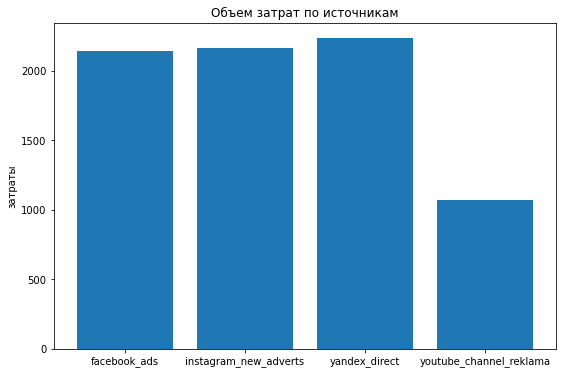

In [33]:
# строим столбчатую диаграмму
plt.figure(figsize=(9, 6))
plt.bar(costs_grouped.index, costs_grouped['cost'])
plt.title('Объем затрат по источникам')
plt.ylabel("затраты")
plt.show()

На youtube тратится почти в два раза меньше средств, чем на любой другой источник. Насколько это разумно можно определить, посчитав удельные затраты на одного пользователя по различным источникам.

Для этого обратимся к последнему датасету и определим количество пользователей, пришедших в игру из разных источников.

In [34]:
#считаем количество пользователей в группировке по источникам
sources_grouped = sources.groupby('source').agg({'user_id': 'count'})

sources_grouped

,user_id
source,
facebook_ads,2726
instagram_new_adverts,3347
yandex_direct,4817
youtube_channel_reklama,2686


Опять же посмотрим на визуализацию такого распределения.

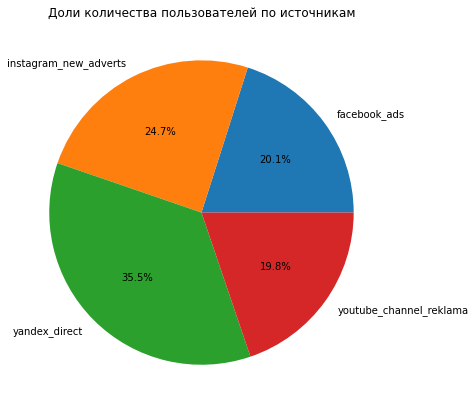

In [35]:
# строим круговую диаграмму
plt.figure(figsize=(7, 7))
plt.pie(sources_grouped['user_id'], labels=sources_grouped.index, autopct='%1.1f%%')
plt.title('Доли количества пользователей по источникам')
plt.show()

Больше всего пользователей (более 35%) приходит с yandex_direct, приток из остальных источников распределен более равномерно (по 20-25%).

Для оценки удельных затрат объединим две полученные таблицы.

In [36]:
# объединяем объемы затрат и количество пользователей по источникам
costs_sources_grouped = costs_grouped.merge(sources_grouped, on='source')

# рассчитываем удельные затраты на пользователя
costs_sources_grouped['cost_per_user'] = costs_sources_grouped['cost']/costs_sources_grouped['user_id']

# сортируем данные по убыванию затрат
costs_sources_grouped.sort_values(by='cost_per_user', ascending=False)

,cost,user_id,cost_per_user
source,,,
facebook_ads,2140.904643,2726,0.785365
instagram_new_adverts,2161.441691,3347,0.645785
yandex_direct,2233.111449,4817,0.463590
youtube_channel_reklama,1068.119204,2686,0.397662


Отразим результаты на диаграмме.

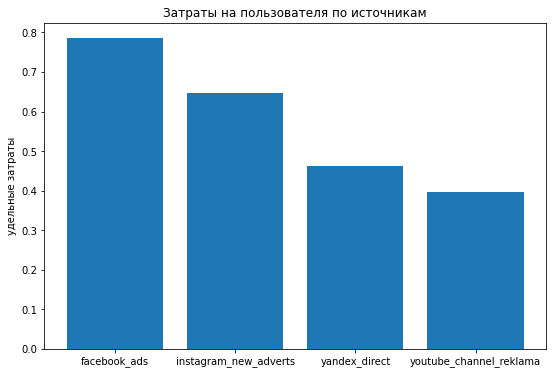

In [37]:
# строим столбчатую диаграмму
plt.figure(figsize=(9, 6))
plt.bar(costs_sources_grouped.index, costs_sources_grouped['cost_per_user'])
plt.title('Затраты на пользователя по источникам')
plt.ylabel("удельные затраты")
plt.show()

Интересный факт: продвижение в youtube, на которое компания тратит меньше всего средств и которое приводит в игру меньше всего пользователей, оказывается наиболее выгодным с точки зрения удельных затрат, а самым дорогим источником при этом оказывается facebook. Возможно, следует перераспределить затраты на привлечение пользователей.

## Формирование модели монетизации

Посчитаем общую выручку, прибыль и рентабельность с учетом того, что показ одного рекламного объявления пользователю приносит 0.07 у.е.

In [38]:
# считаем выручку
revenue = builds*0.07

revenue

8956.92

In [39]:
# считаем прибыль
profit = revenue - total_costs

profit

1353.3430132119774

In [40]:
# считаем рентабельность
profit/total_costs

0.1779876781103876

Рентабельность составляет 17,8%. Это указывает на наличие потенциала для определенного снижения количества рекламы при сохранении прибыльности игры. Так, частота показа рекламы может быть снижена в 1,178 раз или примерно на 15%.

Для более детальной оценки рентабельности нам потребуется объединить данные из всех имеющихся датасетов. В первую очередь, чтобы быть уверенными в расчетах, проверим, что пользователи из таблицы actions совпадают с пользователями из таблицы sources.

In [41]:
missing_users = [x for x in actions['user_id'].unique() if x not in sources['user_id'].unique()]

missing_users

[]

"Лишних" пользователей выявлено не было. Далее можно дополнительно обработать таблицу actions и объединить с записями из sources.

In [42]:
# выделяем дату игрового события в отдельный столбец
actions['day'] = actions['event_datetime'].apply(lambda x: x.date())

# добавляем записи об источниках по каждому пользователю
actions = actions.merge(sources, on='user_id')

actions.head()

,event_datetime,event,building_type,user_id,project_type,day,source
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-04,youtube_channel_reklama
1,2020-05-05 05:20:15,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-05,youtube_channel_reklama
2,2020-05-05 19:24:02,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-05,youtube_channel_reklama
3,2020-05-05 20:59:19,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-05,youtube_channel_reklama
4,2020-05-06 00:52:56,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-06,youtube_channel_reklama


Теперь для каждого пользователя определим число "рекламных" событий и дату начала игры.

In [43]:
# считаем количество событий и первую дату события в группировке по пользователям и источникам для событий, связанных со строительством
actions_grouped = actions[actions['event'] == 'building'].groupby(['user_id', 'source']).agg({'event': 'count', 'day': 'first'})

# меняем тип данных в столбце с датой
actions_grouped['day'] = pd.to_datetime(actions_grouped['day'])

actions_grouped.head()

,,event,day
user_id,source,,
0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads,13,2020-05-06
00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct,9,2020-05-06
001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama,4,2020-05-05
001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts,8,2020-05-05
002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads,12,2020-05-05


Так как данные по затратам на привлечение пользователей смещены на один день относительно начала игровой активности, в целях синхронизации данных добавим один день к моменту привлечения пользователей из различных источников. 

In [44]:
# прибавляем один день к дате привлечения пользователей
costs['day'] = costs['day'].apply(lambda x: (x + timedelta(days=1)))

costs.head()

,source,day,cost
0,facebook_ads,2020-05-04,935.882786
1,facebook_ads,2020-05-05,548.354480
2,facebook_ads,2020-05-06,260.185754
3,facebook_ads,2020-05-07,177.982200
4,facebook_ads,2020-05-08,111.766796


Наконец, сгруппируем данные об активностях по дате и источнику и на основе этого объединим с данными по затратам на привлечение.

In [45]:
# считаем сумму числа событий и количество пользователей в группировке по дате и источнику
data_grouped = actions_grouped.groupby(['day', 'source']).agg({'event': ['count', 'sum']}).reset_index()

# для удобства переименуем столбцы
data_grouped.columns = ['day', 'source', 'users', 'builds']

# добавляем записи о затратах по каждой дате и источнику
data_grouped = data_grouped.merge(costs, on=['day', 'source'])

data_grouped.head()

,day,source,users,builds,cost
0,2020-05-04,facebook_ads,1184,12494,935.882786
1,2020-05-04,instagram_new_adverts,1452,15135,943.204717
2,2020-05-04,yandex_direct,2078,21233,969.139394
3,2020-05-04,youtube_channel_reklama,1146,11773,454.224943
4,2020-05-05,facebook_ads,694,6895,548.354480


Добавим расчеты основных экономических показателей и показателей активности игроков.

In [46]:
# рассчитываем столбец с выручкой
data_grouped['revenue'] = data_grouped['builds']*0.07

# рассчитываем столбец с прибылью
data_grouped['profit'] = data_grouped['revenue'] - data_grouped['cost']

# рассчитываем столбец с рентабельностью
data_grouped['profitability'] = data_grouped['profit']/data_grouped['cost']

#рассчитываем столбец с числом событий, связанных со строительством, на одного пользователя
data_grouped['build_per_user'] = data_grouped['builds']/data_grouped['users']

data_grouped.head()

,day,source,users,builds,cost,revenue,profit,profitability,build_per_user
0,2020-05-04,facebook_ads,1184,12494,935.882786,874.58,-61.302786,-0.065503,10.552365
1,2020-05-04,instagram_new_adverts,1452,15135,943.204717,1059.45,116.245283,0.123245,10.423554
2,2020-05-04,yandex_direct,2078,21233,969.139394,1486.31,517.170606,0.533639,10.217998
3,2020-05-04,youtube_channel_reklama,1146,11773,454.224943,824.11,369.885057,0.814321,10.273124
4,2020-05-05,facebook_ads,694,6895,548.354480,482.65,-65.704480,-0.119821,9.935159


Проверим, что после всех преобразований общий показатель рентабельности остался прежним.

In [47]:
# считаем рентабельность по суммам из таблицы
data_grouped['profit'].sum()/data_grouped['cost'].sum()

0.17798767811038768

Отлично, значения сходятся. Прежде чем смотреть на изменения рентабельности по источникам, оценим ее общую динамику, еще раз преобразовав полученную таблицу. 

In [48]:
# считаем основные показатели в группировке только по дате
data_grouped_all = data_grouped.groupby('day').agg('sum')

# пересчитываем столбец с рентабельностью
data_grouped_all['profitability'] = data_grouped_all['profit']/data_grouped_all['cost']

# пересчитываем столбец с числом событий, связанных со строительством, на одного пользователя
data_grouped_all['build_per_user'] = data_grouped_all['builds']/data_grouped_all['users']

data_grouped_all.head()

,users,builds,cost,revenue,profit,profitability,build_per_user
day,,,,,,,
2020-05-04,5860,60635,3302.451840,4244.45,941.998160,0.285242,10.347270
2020-05-05,3361,32747,1865.004649,2292.29,427.285351,0.229107,9.743231
2020-05-06,1847,16386,1029.431469,1147.02,117.588531,0.114227,8.871684
2020-05-07,1109,8904,620.476519,623.28,2.803481,0.004518,8.028855
2020-05-08,688,4839,391.852033,338.73,-53.122033,-0.135567,7.033430


Посмотрим на динамику общей рентабельности, построив график ее изменения по дням.

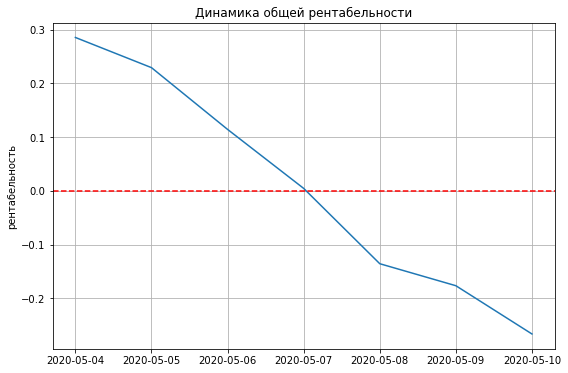

In [49]:
# строим линейный график рентабельности
plt.figure(figsize=(9, 6))
plt.plot(data_grouped_all['profitability'])
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Динамика общей рентабельности')
plt.ylabel("рентабельность")
plt.grid()
plt.show()

Оказывается, что несмотря на наличие у проекта прибыли, значения рентабельности по игрокам, привлеченным во второй половине рассматриваемого периода, являются отрицательными. Попробуем объяснить это.

Из полученной таблицы можно заметить, что затраты на привлечения пользователей существенно падают каждый день. Построим соответствующий график затрат.

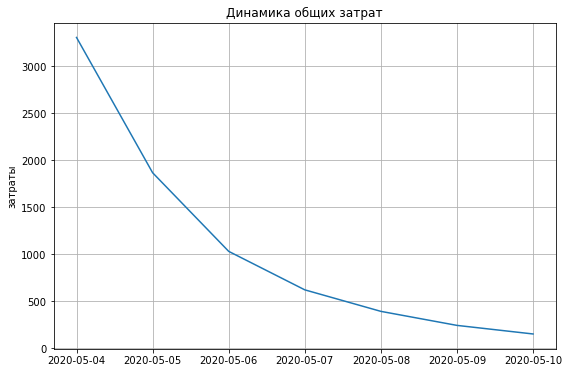

In [50]:
# строим линейный график затрат
plt.figure(figsize=(9, 6))
plt.plot(data_grouped_all['cost'])
plt.title('Динамика общих затрат')
plt.ylabel("затраты")
plt.grid()
plt.show()

Действительно, затраты падают, а значит падает и число привлекаемых игроков. Можно предположить, что чем больше игроков в игре, тем активнее они взаимодействуют между собой и совершают различные действия, направленные на победу.

Оценим это явление через график динамики числа совершаемых "рекламных" событий на одного игрока.

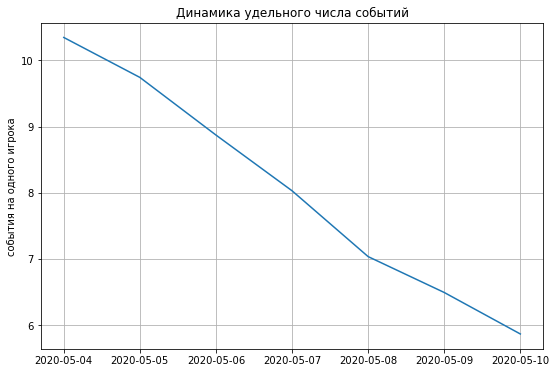

In [51]:
# строим линейный график удельного числа событий 
plt.figure(figsize=(9, 6))
plt.plot(data_grouped_all['build_per_user'])
plt.title('Динамика удельного числа событий')
plt.ylabel("события на одного игрока")
plt.grid()
plt.show()

Число событий на игрока и правда падает с уровня более 10 до 6 и меньше. Логично, что для обеспечения стабильности показателей прибыли надо также стабилизировать активность пользователей игры.

Перейдем к оценке рентабельности по различным источникам привлечения пользователей. Отобразим динамику по ним на одном графике.

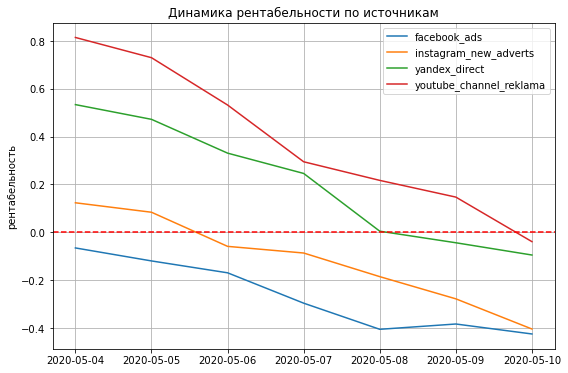

In [52]:
# строим линейные графики рентабельности по каждому источнику 
plt.figure(figsize=(9, 6))
for source in data_grouped['source'].unique():
    plt.plot(data_grouped['day'].unique(), data_grouped[data_grouped['source'] == source]['profitability'], label=source)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Динамика рентабельности по источникам')
plt.ylabel("рентабельность")
plt.grid()
plt.legend()
plt.show()

Мы видим, что только yandex_direct и youtube позволяют поддерживать по большей части положительную рентабельность. Facebook и instagram же практически/сразу "уходят в минус".

Однако в целях рассмотрения альтернативных моделей монетизации предлагается пока оставить существующую структуру затрат. В рамках данного исследования планируется рассмотреть две такие модели.

### Первый вариант - привязка рекламы к конкретным типам строящихся объектов

Сейчас реклама показывается пользователю при выборе любого здания на экране постройки. При этом мы можем сократить количество рекламы не более чем на 15%. Из предыдущего анализа следует, что объекты типа "исследовательский центр" занимают всего 11% от общего числа строящихся игроками зданий. Соответственно, можно не показывать рекламу при строительстве объектов данного типа и сохранить прибыльность проекта.

Рассчитаем показатели рентабельности при таком сценарии. Для этого "пересоберем" предыдущие таблицы с новым условием - исключим исследовательские центры из строящихся объектов, оставив только космопорты и сборочные цеха.

In [53]:
# считаем количество событий и первую дату события в группировке по пользователям и источникам для событий, связанных со строительством космопортов или сборочных цехов
actions_grouped = actions[(actions['building_type'] == 'assembly_shop') | (actions['building_type'] == 'spaceport')].groupby(['user_id', 'source']).agg({'event': 'count', 'day': 'first'})

# меняем тип данных в столбце с датой
actions_grouped['day'] = pd.to_datetime(actions_grouped['day'])

actions_grouped.head()

,,event,day
user_id,source,,
0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads,12,2020-05-06
00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct,9,2020-05-06
001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama,4,2020-05-05
001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts,8,2020-05-05
002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads,11,2020-05-05


In [54]:
# считаем сумму числа событий и количество пользователей в группировке по дате и источнику
data_grouped_var_1 = actions_grouped.groupby(['day', 'source']).agg({'event': ['count', 'sum']}).reset_index()

# для удобства переименуем столбцы
data_grouped_var_1.columns = ['day', 'source', 'users', 'builds']

# добавляем записи о затратах по каждой дате и источнику
data_grouped_var_1 = data_grouped_var_1.merge(costs, on=['day', 'source'])

# рассчитываем столбец с выручкой
data_grouped_var_1['revenue'] = data_grouped_var_1['builds']*0.07

# рассчитываем столбец с прибылью
data_grouped_var_1['profit'] = data_grouped_var_1['revenue'] - data_grouped_var_1['cost']

# считаем основные показатели в группировке только по дате
data_grouped_var_1 = data_grouped_var_1.groupby('day').agg('sum')

# рассчитываем столбец с рентабельностью
data_grouped_var_1['profitability'] = data_grouped_var_1['profit']/data_grouped_var_1['cost']

# рассчитываем столбец с числом событий, связанных со строительством выбранных объектов, на одного пользователя
data_grouped_var_1['build_per_user'] = data_grouped_var_1['builds']/data_grouped_var_1['users']

data_grouped_var_1.head()

,users,builds,cost,revenue,profit,profitability,build_per_user
day,,,,,,,
2020-05-04,5860,53787,3302.451840,3765.09,462.638160,0.140089,9.178669
2020-05-05,3361,28987,1865.004649,2029.09,164.085351,0.087981,8.624517
2020-05-06,1847,14615,1029.431469,1023.05,-6.381469,-0.006199,7.912832
2020-05-07,1109,7951,620.476519,556.57,-63.906519,-0.102996,7.169522
2020-05-08,688,4405,391.852033,308.35,-83.502033,-0.213096,6.402616


Посчитаем рентабельность в рассматриваемом сценарии.

In [55]:
# считаем рентабельность по суммам из таблицы
data_grouped_var_1['profit'].sum()/data_grouped_var_1['cost'].sum()

0.0478397225206025

Рентабельность снизилась до 4,8%, пропорционально числу "рекламных" событий, связанных со строительством определенных типов зданий.

Посмотрим также на график динамики рентабельности в данном сценарии.

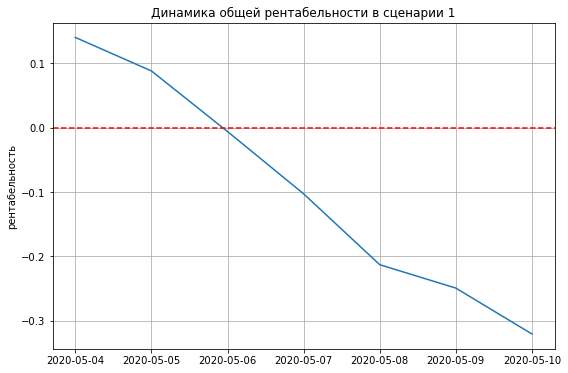

In [56]:
# строим линейный график рентабельности
plt.figure(figsize=(9, 6))
plt.plot(data_grouped_var_1['profitability'])
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Динамика общей рентабельности в сценарии 1')
plt.ylabel("рентабельность")
plt.grid()
plt.show()

Мы видим, что затраты на привлечение новых пользователей в этом случае перестают окупаться даже раньше, чем в "базовом" варианте. Рассмотрим еще один альтернативный сценарий.

### Второй вариант - показ рекламы, начиная не с первого события, связанного с постройкой зданий

Мы помним, что в среднем пользователи осуществляют около 9 "рекламных" событий, связанных со строительством объектов. Выявленный порог максимального снижения количества рекламы позволяет уменьшить число таких событий до 8.

Рассчитаем показатели рентабельности при таком сценарии. Для этого опять же "пересоберем" предыдущие таблицы с новым условием - уменьшим число событий, совершаемых каждым пользователем, на 1.

In [57]:
# считаем количество событий и первую дату события в группировке по пользователям и источникам для событий, связанных со строительством
actions_grouped = actions[actions['event'] == 'building'].groupby(['user_id', 'source']).agg({'event': 'count', 'day': 'first'})

# меняем тип данных в столбце с датой
actions_grouped['day'] = pd.to_datetime(actions_grouped['day'])

# уменьшаем число событий, совершенных каждым пользователем, на единицу
actions_grouped['event'] = actions_grouped['event'] - 1

actions_grouped.head()

,,event,day
user_id,source,,
0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads,12,2020-05-06
00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct,8,2020-05-06
001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama,3,2020-05-05
001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts,7,2020-05-05
002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads,11,2020-05-05


In [58]:
# считаем сумму числа событий и количество пользователей в группировке по дате и источнику
data_grouped_var_2 = actions_grouped.groupby(['day', 'source']).agg({'event': ['count', 'sum']}).reset_index()

# для удобства переименуем столбцы
data_grouped_var_2.columns = ['day', 'source', 'users', 'builds']

# добавляем записи о затратах по каждой дате и источнику
data_grouped_var_2 = data_grouped_var_2.merge(costs, on=['day', 'source'])

# рассчитываем столбец с выручкой
data_grouped_var_2['revenue'] = data_grouped_var_2['builds']*0.07

# рассчитываем столбец с прибылью
data_grouped_var_2['profit'] = data_grouped_var_2['revenue'] - data_grouped_var_2['cost']

# считаем основные показатели в группировке только по дате
data_grouped_var_2 = data_grouped_var_2.groupby('day').agg('sum')

# рассчитываем столбец с рентабельностью
data_grouped_var_2['profitability'] = data_grouped_var_2['profit']/data_grouped_var_2['cost']

# рассчитываем столбец с числом событий, связанных со строительством выбранных объектов, на одного пользователя
data_grouped_var_2['build_per_user'] = data_grouped_var_2['builds']/data_grouped_var_2['users']

data_grouped_var_2.head()

,users,builds,cost,revenue,profit,profitability,build_per_user
day,,,,,,,
2020-05-04,5860,54775,3302.451840,3834.25,531.798160,0.161031,9.347270
2020-05-05,3361,29386,1865.004649,2057.02,192.015351,0.102957,8.743231
2020-05-06,1847,14539,1029.431469,1017.73,-11.701469,-0.011367,7.871684
2020-05-07,1109,7795,620.476519,545.65,-74.826519,-0.120595,7.028855
2020-05-08,688,4151,391.852033,290.57,-101.282033,-0.258470,6.033430


Посчитаем рентабельность в рассматриваемом сценарии.

In [59]:
# считаем рентабельность по суммам из таблицы
data_grouped_var_2['profit'].sum()/data_grouped_var_2['cost'].sum()

0.053004396997922275

Рентабельность оказалась чуть выше, чем в предыдущем сценарии, и составляет 5,3%.

Посмотрим также на график динамики рентабельности в данном сценарии.

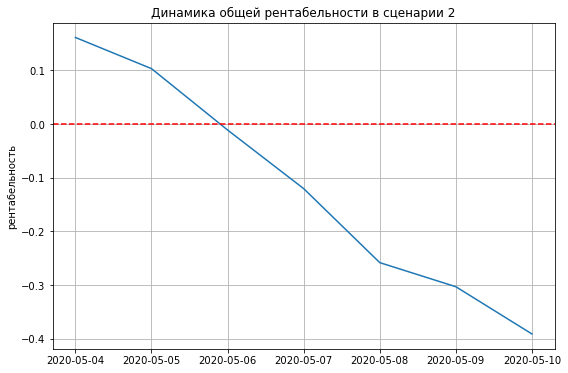

In [60]:
# строим линейный график рентабельности
plt.figure(figsize=(9, 6))
plt.plot(data_grouped_var_2['profitability'])
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Динамика общей рентабельности в сценарии 2')
plt.ylabel("рентабельность")
plt.grid()
plt.show()

В целом графики в двух сценариях имеют схожий вид, однако рассматриваемый вариант обладает двумя важными преимуществами:
1) Большая гибкость - в перспективе показ рекламы можно начинать с 3-го, 4-го, 5-го... и т.д. события, без привязки к какой-либо внутриигровой статистике;

2) Большая "дружелюбность" - пользователь не получит дополнительного рекламного сообщения именно в начале своего знакомства с игрой, а не в конце (здание исследовательского центра из предыдущего сценария, скорее всего, будет строиться в конце игры, так как обеспечивает победу через реализацию проекта спутника).

## Категоризация данных

Посмотрим, как влияет на показатели игровой активности принадлежность пользователей к разным категориям. Выделим категории пользователей, закончивших первый уровень, и пользователей, бросивших игру. Также рассмотрим категории пользователей, прошедших первый уровень разными способами - через реализацию проекта, либо за счет победы над противником.

Добавим в данные об активности пользователей интересующие нас категориальные признаки, включая признак совершения целевого события, связанного со строительством зданий в игре.

In [61]:
# добавим столбец с бинарным признаком завершения уровня
actions['finish'] = (actions['event'] == 'finished_stage_1')

# добавим столбец с бинарным признаком реализации проекта
actions['project'] = (actions['event'] == 'project')

# добавим столбец с бинарным признаком строительства здания
actions['building'] = (actions['event'] == 'building')

actions.head()

,event_datetime,event,building_type,user_id,project_type,day,source,finish,project,building
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-04,youtube_channel_reklama,False,False,True
1,2020-05-05 05:20:15,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-05,youtube_channel_reklama,False,False,True
2,2020-05-05 19:24:02,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-05,youtube_channel_reklama,False,False,True
3,2020-05-05 20:59:19,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-05,youtube_channel_reklama,False,False,True
4,2020-05-06 00:52:56,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-06,youtube_channel_reklama,False,False,True


Еще раз сгруппируем данные по пользователям c учетом добавленных признаков.

In [62]:
# считаем первую и последнюю дату события, наличие признака окончания уровня/реализации проекта, а также сумму числа целевых событий в группировке по пользователям
actions_grouped = actions.groupby('user_id').agg({'finish': 'max', 'project': 'max', 'building': 'sum', 'event_datetime': ['first', 'last']})

# для удобства переименуем столбцы
actions_grouped.columns = ['finish', 'project', 'builds', 'first_date', 'last_date']

actions_grouped.head()

,finish,project,builds,first_date,last_date
user_id,,,,,
0001f83c-c6ac-4621-b7f0-8a28b283ac30,False,False,13,2020-05-06 01:07:37,2020-05-20 11:26:06
00151b4f-ba38-44a8-a650-d7cf130a0105,False,False,9,2020-05-06 03:09:12,2020-05-18 10:46:52
001aaea6-3d14-43f1-8ca8-7f48820f17aa,False,False,4,2020-05-05 18:08:52,2020-05-14 09:21:27
001d39dc-366c-4021-9604-6a3b9ff01e25,True,False,8,2020-05-05 21:02:05,2020-05-12 07:40:47
002f508f-67b6-479f-814b-b05f00d4e995,False,False,12,2020-05-05 13:49:58,2020-05-22 02:46:45


Посчитаем продолжительность игры для каждого пользователя на основе полученных значений.

In [63]:
# рассчитываем продолжительность игры в часах
actions_grouped['duration'] = (actions_grouped['last_date'] - actions_grouped['first_date']) / np.timedelta64(1, 'h')

actions_grouped.head()

,finish,project,builds,first_date,last_date,duration
user_id,,,,,,
0001f83c-c6ac-4621-b7f0-8a28b283ac30,False,False,13,2020-05-06 01:07:37,2020-05-20 11:26:06,346.308056
00151b4f-ba38-44a8-a650-d7cf130a0105,False,False,9,2020-05-06 03:09:12,2020-05-18 10:46:52,295.627778
001aaea6-3d14-43f1-8ca8-7f48820f17aa,False,False,4,2020-05-05 18:08:52,2020-05-14 09:21:27,207.209722
001d39dc-366c-4021-9604-6a3b9ff01e25,True,False,8,2020-05-05 21:02:05,2020-05-12 07:40:47,154.645000
002f508f-67b6-479f-814b-b05f00d4e995,False,False,12,2020-05-05 13:49:58,2020-05-22 02:46:45,396.946389


Выделим категории пользователей, завершивших первый уровень, и пользователей, покинувших игру.

In [64]:
# выделяем категорию пользователей, завершивших первый уровень
winners_all = actions_grouped[actions_grouped['finish'] == True]

winners_all.head()

,finish,project,builds,first_date,last_date,duration
user_id,,,,,,
001d39dc-366c-4021-9604-6a3b9ff01e25,True,False,8,2020-05-05 21:02:05,2020-05-12 07:40:47,154.645000
003ee7e8-6356-4286-a715-62f22a18d2a1,True,False,8,2020-05-05 08:31:04,2020-05-17 21:47:49,301.279167
004074f8-251a-4776-922c-8348dca1a2f6,True,False,12,2020-05-04 01:07:35,2020-05-16 19:57:40,306.834722
00464e5e-28ed-4be6-bf44-517ef7b3937b,True,False,8,2020-05-04 08:35:29,2020-05-15 16:02:01,271.442222
0056c007-c082-43cc-bdef-afc49bca4cb9,True,False,3,2020-05-10 11:49:47,2020-05-16 13:48:39,145.981111


In [65]:
# выделяем категорию пользователей, покинувших игру
quitters_all = actions_grouped[actions_grouped['finish'] == False]

quitters_all.head()

,finish,project,builds,first_date,last_date,duration
user_id,,,,,,
0001f83c-c6ac-4621-b7f0-8a28b283ac30,False,False,13,2020-05-06 01:07:37,2020-05-20 11:26:06,346.308056
00151b4f-ba38-44a8-a650-d7cf130a0105,False,False,9,2020-05-06 03:09:12,2020-05-18 10:46:52,295.627778
001aaea6-3d14-43f1-8ca8-7f48820f17aa,False,False,4,2020-05-05 18:08:52,2020-05-14 09:21:27,207.209722
002f508f-67b6-479f-814b-b05f00d4e995,False,False,12,2020-05-05 13:49:58,2020-05-22 02:46:45,396.946389
003b80c6-4164-4157-bb2a-03d0181d39c4,False,False,14,2020-05-04 09:10:22,2020-05-12 15:23:37,198.220833


Также разделим "победителей" на тех, кто реализовал проект спутника, и тех, кто одержал боевую победу над противником.

In [66]:
# выделяем категорию пользователей, победивших противника в бою
winners_fight = winners_all[winners_all['project'] == False]

winners_fight.head()

,finish,project,builds,first_date,last_date,duration
user_id,,,,,,
001d39dc-366c-4021-9604-6a3b9ff01e25,True,False,8,2020-05-05 21:02:05,2020-05-12 07:40:47,154.645000
003ee7e8-6356-4286-a715-62f22a18d2a1,True,False,8,2020-05-05 08:31:04,2020-05-17 21:47:49,301.279167
004074f8-251a-4776-922c-8348dca1a2f6,True,False,12,2020-05-04 01:07:35,2020-05-16 19:57:40,306.834722
00464e5e-28ed-4be6-bf44-517ef7b3937b,True,False,8,2020-05-04 08:35:29,2020-05-15 16:02:01,271.442222
0056c007-c082-43cc-bdef-afc49bca4cb9,True,False,3,2020-05-10 11:49:47,2020-05-16 13:48:39,145.981111


In [67]:
# выделяем категорию пользователей, реализовавших проект спутника
winners_project = winners_all[winners_all['project'] == True]

winners_project.head()

,finish,project,builds,first_date,last_date,duration
user_id,,,,,,
006380d6-67a6-45de-ab1e-6eb54ad8dbe8,True,True,11,2020-05-04 16:43:39,2020-05-16 11:22:33,282.648333
00be7371-fa79-4fbd-b8e7-8ba32e3f8f82,True,True,12,2020-05-08 21:57:44,2020-05-24 19:05:12,381.124444
00c2b9f2-2615-439c-aed0-6974e4c6c1c1,True,True,11,2020-05-07 10:26:09,2020-05-27 11:38:47,481.210556
00de2809-403e-4476-a2f7-ca1b11700190,True,True,13,2020-05-04 07:48:50,2020-05-18 09:34:10,337.755556
00e83261-5fd4-4939-9616-802b5a0202c6,True,True,13,2020-05-05 15:49:57,2020-05-20 09:35:04,353.751944


Далее оценим основные показатели пользовательской активности в разных категориях. Начнем с параметра средней продолжительности игры.

In [68]:
# считаем среднюю продолжительность игры среди пользователей, победивших противника
winners_fight['duration'].mean()

266.5066878286794

In [69]:
# считаем среднюю продолжительность игры среди пользователей, реализовавших проект
winners_project['duration'].mean()

323.01364862450947

Мы видим, что "научная" победа занимает больше времени, чем "военная" (в среднем на 57 часов). Интересно, как это влияет на число целевых событий, связанных со строительством.

In [70]:
# считаем среднее число целевых событий среди пользователей, победивших противника
winners_fight['builds'].mean()

9.411541381928625

In [71]:
# считаем среднее число целевых событий среди пользователей, реализовавших проект
winners_project['builds'].mean()

12.64790996784566

Логично, что те, кто дольше играет, совершает больше целевых событий, хотя, вероятно, сам стиль игры, связанный с реализацией проекта спутника, может предполагать больший объем строительства.

Теперь посмотрим на различие в числе целевых событий между пользователями, прошедшими первый уровень, и пользователями, покинувшими игру.

In [72]:
# считаем среднее число целевых событий среди пользователей, завершивших первый уровень
winners_all['builds'].mean()

10.449716348633316

In [73]:
# считаем среднее число целевых событий среди пользователей, покинувших игру
quitters_all['builds'].mean()

8.657043433432143

Если пользователи и бросали игру, то в целом это происходило не потому, что они посмотрели больше рекламы, чем остальные игроки. Возможно, такие пользователи были менее "устойчивы" к рекламе, хотя повлиять на их уход могли и другие причины, связанные с геймплеем, сеттингом или иными особенностями игры. 

В любом случае, несмотря на наличие видимых отличий между категориями, мы должны проверить их на статистическую значимость, прежде чем делать окончательные выводы.

## Проверка гипотез

Сформируем гипотезы, исходя из ранее проведенного сравнения параметров игровой активности между различными категориями пользователей.

### Первая гипотеза - существует различие во времени прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком

В этом случае нулевая гипотеза будет сформулирована, исходя из принципа равенства, а альтернативная - как противоположная нулевой:
- h0: среднее время прохождения уровня пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком, равно;
- h1: среднее время прохождения уровня пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком, не равно.

Для проверки используем t-тест с параметром equal_var. Критерий значимости возьмем на уровне 5%.

In [74]:
#получаем результат теста
result = st.ttest_ind(winners_fight['duration'], winners_project['duration'], equal_var=False) 

result.pvalue 

5.708058235071826e-107

Значение p-value крайне мало и очевидно ниже критерия значимости. Следовательно, нулевую гипотезу можно отвергнуть и считать, что средняя продолжительность игры в двух рассматриваемых категориях действительно различается.

### Вторая гипотеза - существует различие в количестве действий, вызывающих показ рекламы, между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком

Сформулируем нулевую и альтернативную гипотезу аналогичным образом:

- h0: среднее число целевых действий, выполняемых пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком, равно;
- h1: среднее число целевых действий, выполняемых пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком, не равно.

Для проверки также используем t-тест с критерием значимости на уровне 5%.

In [75]:
#получаем результат теста
result = st.ttest_ind(winners_fight['builds'], winners_project['builds'], equal_var=False) 

result.pvalue

0.0

Значение p-value так мало, что приближается к нулю. Мы с большой уверенностью можем отвергнуть нулевую гипотезу и говорить о различии в числе событий, вызывающих показ рекламы, в двух категориях.

### Третья гипотеза - существует различие в количестве действий, вызывающих показ рекламы, между пользователями, прошедшими первый уровень, и пользователями, покинувшими игру

Сформулируем нулевую и альтернативную гипотезу аналогичным образом:

- h0: среднее число целевых действий, выполняемых пользователями, прошедшими первый уровень, и пользователями, покинувшими игру, равно;
- h1: среднее число целевых действий, выполняемых пользователями, прошедшими первый уровень, и пользователями, покинувшими игру, не равно.

Для проверки также используем t-тест с критерием значимости на уровне 5%.

In [76]:
#получаем результат теста
result = st.ttest_ind(winners_all['builds'], quitters_all['builds'], equal_var=False) 

result.pvalue

5.999381139920726e-174

Значение p-value опять крайне мало и очевидно ниже критерия значимости. Следовательно, нулевую гипотезу можно отвергнуть и считать, что среднее число целевых действий в двух рассматриваемых категориях действительно различается. Причем, как мы помним, в случае пользователей, покинувших игру, количество "рекламных" событий было ниже, чем в случае оставшихся игроков.

# Выводы и рекомендации

На основании результатов исследования можно сделать следующие выводы:
1) В "базовом" сценарии, когда показ рекламы в игровом приложении происходит на экране выбора постройки, рентабельность проекта составляет 17,8%, что говорит о наличии потенциала для снижения количества рекламы.

2) Были предложены две альтернативные модели монетизации и рассчитаны соответствующие им показатели рентабельности:
- показ рекламы только при постройке сборочных цехов и космопортов, без учета исследовательских центров, обеспечивает уровень рентабельности 4,8%;
- показ рекламы, начиная со 2-го действия по выбору постройки в игре, обеспечивает уровень рентабельности 5,3%.

3) Помимо более высокого уровня рентабельности, вторая модель обладает рядом существенных преимуществ:
- в перспективе показ рекламы можно начинать с 3-го, 4-го, 5-го... события, что обеспечивает большую гибкость модели;
- пользователи не получают дополнительного рекламного сообщения именно в начале своего знакомства с игрой, что делает такой подход более "дружелюбным" для игроков.

4) Последующий рост рентабельности и/или снижение количества рекламы могут быть достигнуты за счет оптимизации рекламных затрат, в частности:
- уменьшение объема затрат на facebook и instagram в пользу yandex_direct и youtube;
- более равномерное распределение затрат по времени в целях обеспечения стабильного притока игроков.

5) Проверка статистических гипотез показала, что игроки в целом проводят больше времени в игре и совершают большее число целевых действий, вызывающих показ рекламы, при попытке достичь победы за счет реализации проекта спутника - возможно, следует стимулировать подобное игровое поведение.

6) Игроки, покинувшие игру, сталкивались с внутриигровой рекламой в меньшем объеме, чем пользователи, завершившие первый уровень. В связи с этим, рекомендуется дополнительно изучить причины ухода игроков и детальнее оценить степень влияния рекламы на пользовательское восприятие (можно предложить A/B-тестирование с наличием и отсутствием рекламы в игре).